# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [35]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [36]:
# YOUR CODE HERE
data['verse'][18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [37]:
import unidecode

for i in range(len(data)):
    data['verse'][i] = unidecode.unidecode(data['verse'][i])

In [38]:
data['verse'][18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [39]:
# YOUR CODE HERE
# Check Duplicate
data['verse'].duplicated().sum()

946

In [40]:
data = data.drop_duplicates()

In [41]:
data.shape

(3031, 2)

In [42]:
# Drop Duplicate
data = data.drop_duplicates(subset=['verse'])

In [43]:
data.shape

(3029, 2)

In [44]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [45]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     777
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [46]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [47]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [48]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [49]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [50]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.26% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [58]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.text import text_to_word_sequence

data["seq"] = data['verse'].apply(lambda x : text_to_word_sequence(x)) 
data["seq"]

<ipython-input-58-13b7034a35f8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["seq"] = data['verse'].apply(lambda x : text_to_word_sequence(x))


0                             [ayy, woah, ayy, ayy, yeah]
1       [i'm, makin', a, change, today, the, liquor, b...
2       [i, can't, just, be, with, you, and, only, you...
3       [well, summer, all, i, did, was, rest, okay, a...
4       [i'm, makin', a, change, today, the, liquor, b...
                              ...                        
3970    [dame, was, like, yo, you, got, a, deal, with,...
3971    [then, one, day, i, just, went, ahead, and, pl...
3972           [i, ain't, gonna, front, it's, kinda, hot]
3973    [like, they, still, weren't, looking, at, me, ...
3974    [you, gotta, be, under, an, umbrella, you'll, ...
Name: seq, Length: 3029, dtype: object

In [59]:
data.head()

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

<AxesSubplot:xlabel='seq', ylabel='Density'>

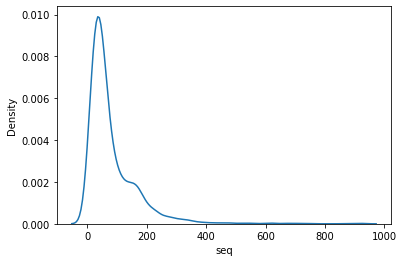

In [62]:
# YOUR CODE HERE
sns.kdeplot(data = data, x=data.seq.apply(len))

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [63]:
# YOUR CODE HERE
data["seq"] = data["seq"].apply(lambda x : x[:300])

❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [88]:
# YOUR CODE HERE
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=data['seq'], vector_size=100, min_count=0, epochs=50)

def embed_sentence(sentence, word2vec=word2vec):
    embedded_sentence = []
    
    for word in sentence:
        if word in word2vec.wv:
            embedded_sentence.append(word2vec.wv[word])
            
    return np.array(embedded_sentence)

data['embed'] = data["seq"].map(embed_sentence)

In [91]:
len(data["embed"])

3029

In [92]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [94]:
# YOUR CODE HERE
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = pad_sequences(data['embed'], dtype='float32', padding='post', maxlen=300)

In [106]:
X.shape

(3029, 300, 100)

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [96]:
data

,artist,verse,seq,embed
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[0.32551405, 0.28708175, 1.1292497, -1.160646..."
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[-1.1351925, -2.7911081, -1.99451, 0.8077893,..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[0.1139799, 0.9130863, 0.16542466, -0.3137988..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[-1.8420494, -0.99406457, -1.4677347, 3.33088..."
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[-1.1351925, -2.7911081, -1.99451, 0.8077893,..."
...,...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,...","[[-0.5240678, 0.8660054, 0.26125026, 0.2237733..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl...","[[0.7537037, 1.6456068, 1.978234, -0.7333428, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, ain't, gonna, front, it's, kinda, hot]","[[0.1139799, 0.9130863, 0.16542466, -0.3137988..."
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, weren't, looking, at, me, ...","[[0.34876388, 2.9162152, -1.1980822, 0.557526,..."


In [99]:
# YOUR CODE HERE
from sklearn.preprocessing import OneHotEncoder
import numpy as np

In [100]:
data.artist.unique()

array(['Drake', 'Ed Sheeran', 'Kanye West'], dtype=object)

In [101]:
ohe = OneHotEncoder(sparse = False) # Instanciate encoder
ohe.fit(data[['artist']]) # Fit encoder

artist_encoded = ohe.transform(data[['artist']]) # Encode alley
data["Drake"],data["Ed Sheeran"],data['Kanye West'] = artist_encoded.T # Transpose encoded Artist back into dataframe
data.head()


,artist,verse,seq,embed,Drake,Ed Sheeran,Kanye West
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]","[[0.32551405, 0.28708175, 1.1292497, -1.160646...",1.0,0.0,0.0
1,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[-1.1351925, -2.7911081, -1.99451, 0.8077893,...",1.0,0.0,0.0
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, can't, just, be, with, you, and, only, you...","[[0.1139799, 0.9130863, 0.16542466, -0.3137988...",1.0,0.0,0.0
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a...","[[-1.8420494, -0.99406457, -1.4677347, 3.33088...",1.0,0.0,0.0
4,Drake,I'm makin' a change today The liquor been taki...,"[i'm, makin', a, change, today, the, liquor, b...","[[-1.1351925, -2.7911081, -1.99451, 0.8077893,...",1.0,0.0,0.0


In [107]:
y = data[['Drake', 'Ed Sheeran', 'Kanye West']]

In [108]:
y.shape

(3029, 3)

In [112]:
y

,Drake,Ed Sheeran,Kanye West
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0
...,...,...,...
3970,0.0,0.0,1.0
3971,0.0,0.0,1.0
3972,0.0,0.0,1.0
3973,0.0,0.0,1.0


👉 We train/test split the dataset below for you

In [109]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [110]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [119]:
data['artist'].value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     777
Name: artist, dtype: int64

In [120]:
# YOUR CODE HERE
from sklearn.metrics import accuracy_score

y_pred = [1, 0, 0]
score_baseline = accuracy_score(y_test, [y_pred]*len(y_test))

print('Baseline accuracy: ', score_baseline)

Baseline accuracy:  0.43564356435643564


❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [180]:
# YOUR CODE HERE
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers

def init_model():
    model = Sequential()
    model.add(layers.Masking(mask_value=0))
    model.add(layers.LSTM(20, activation='tanh'))
    model.add(layers.Dense(15, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    
    #opt = optimizers.Adam(learning_rate=0.01)

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [181]:
# YOUR CODE HERE
from tensorflow.keras.callbacks import EarlyStopping

model = init_model()

es = EarlyStopping(patience=5, restore_best_weights=True)

model.fit(X_train, y_train, 
          batch_size = 32,
          epochs=50,
          validation_split=0.3,
          callbacks=[es]
         )

Epoch 1/50
53/53 [==============================] - 11s 147ms/step - loss: 0.7027 - accuracy: 0.4389 - val_loss: 0.6387 - val_accuracy: 0.4732
Epoch 2/50
53/53 [==============================] - 6s 111ms/step - loss: 0.6197 - accuracy: 0.4774 - val_loss: 0.6036 - val_accuracy: 0.4732
Epoch 3/50
53/53 [==============================] - 6s 118ms/step - loss: 0.5970 - accuracy: 0.4579 - val_loss: 0.5865 - val_accuracy: 0.4814
Epoch 4/50
53/53 [==============================] - 6s 110ms/step - loss: 0.5739 - accuracy: 0.4940 - val_loss: 0.5697 - val_accuracy: 0.5296
Epoch 5/50
53/53 [==============================] - 6s 115ms/step - loss: 0.5218 - accuracy: 0.6037 - val_loss: 0.5405 - val_accuracy: 0.5818
Epoch 6/50
53/53 [==============================] - 6s 112ms/step - loss: 0.4876 - accuracy: 0.6579 - val_loss: 0.5125 - val_accuracy: 0.6107
Epoch 7/50
53/53 [==============================] - 6s 114ms/step - loss: 0.4386 - accuracy: 0.6900 - val_loss: 0.5065 - val_accuracy: 0.6245
Epoch

❓ **Plot the training and validation losses through training**

In [182]:
def plot_loss_accuracy(history):
    fig, ax = plt.subplots(1,2, figsize=(13,5))
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))

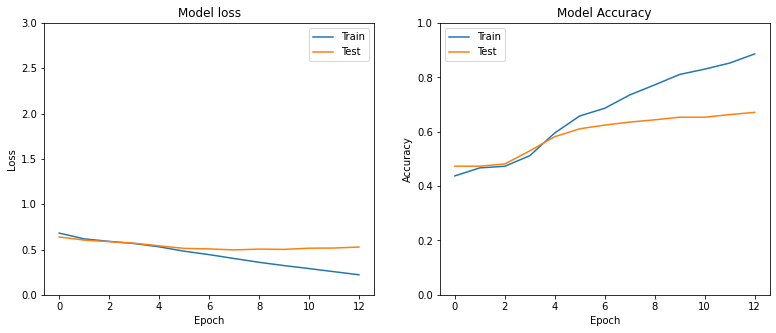

In [184]:
plot_loss_accuracy(model.history)

In [185]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE

    


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

<Figure size 432x288 with 0 Axes>

❓ **Save your accuracy on test set as `score_test`**

In [186]:
# YOUR CODE HERE
score_test = model.evaluate(X_test, y_test)
score_test

19/19 [==============================] - 1s 26ms/step - loss: 0.4902 - accuracy: 0.6320


[0.49024051427841187, 0.632013201713562]

🧪 **Send your results below**

In [187]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()